In [ ]:
# Copyright (c) [2023] [NeurIPS authors, 11410]
# 
# This file is licensed under the MIT License.
# See the LICENSE file in the project root for full license information.
#

import numpy as np
import matplotlib.pyplot as plt
from run import agents, run_agent, AgentStats, compute_statistics
from numpy.typing import NDArray
from typing import NamedTuple, Sequence, Tuple
from deepsea import MultiRewardsDeepSea
import multiprocessing as mp
from scipy.stats import t as tstudent
import pickle
import lzma
import seaborn as sns
from deepsea import MultiRewardsDeepSea
import pandas as pd
from scipy.stats import entropy
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Results(NamedTuple):
    training_rewards: NDArray[np.float64]
    greedy_rewards: Sequence[Tuple[int, NDArray[np.float64]]]
    regret: NDArray[np.float64]
    agent_stats: AgentStats
    
    
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)


In [3]:
TITLE_SIZE = 22
LEGEND_SIZE = 14
TICK_SIZE = 14
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 16
FONT_SIZE = TITLE_SIZE-4


rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        r'\usepackage{amsmath}',
    ]
}
plt.rcParams.update(rc_parameters)


In [5]:
SIZES = [10, 20, 30, 40, 50]
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 5000}
AGENTS = ['explorative_generative_off_policy', 'boot_dqn_torch', 'boot_dqn_torch_modified', 'ids']


raw_data = {x: {agent: None for agent in AGENTS} for x in SIZES}
data = {}
df = pd.DataFrame({
    'method': [],
    'size': [],
    'spread': [],
    'median_avg_visit': [],
    'std_avg_visit': []
})


for size in SIZES:
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:               
            raw_data[size] = pickle.load(f)
            res = np.array(raw_data[size].training_rewards)
            if agent not in data: data[agent] = {}


            x: Results = raw_data[size]
            spread = []
            mask = np.zeros_like(x.agent_stats[0].total_num_visits, dtype=bool)
            mask[np.tril_indices_from(mask)] = True
            
            # n^2-n is the minimum spread possible, while n^2-2 is the maximum possible spread (as long as the agent has visited all states at least once)
            spread = np.array([
                np.std(x.agent_stats[i].last_visit[mask]/ ( size*EPISODES[size]) )
                for i in range(len(x.agent_stats))])
            median_avg_visit = np.array([
                np.median(x.agent_stats[i].frequency_visits[mask])
                for i in range(len(x.agent_stats))])
            std_avg_visit = np.array([
                np.std(x.agent_stats[i].frequency_visits[mask])
                for i in range(len(x.agent_stats))])
   
            for i in range(len(spread)):
                df.loc[len(df)] = [agent, size, spread[i], median_avg_visit[i], std_avg_visit[i]]


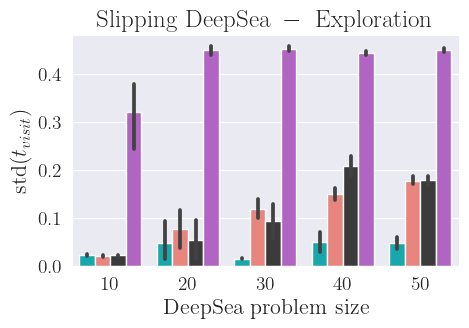

In [36]:
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']

labels_agents = {
    
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative_generative_off_policy': r'\textsc{DBMF-BPI}',
    'boot_dqn_torch': r'\textsc{BSP}',
    
    'ids': r'\textsc{IDS}',
}
colors = {
    'boot_dqn_torch': '#f8766d',
    'boot_dqn_torch_modified': '#3B3B3B',
    'explorative_generative_off_policy': '#00bfc4',
    'ids': 'mediumorchid',
}

sns.set_style("darkgrid", rc=rc_parameters)
#color_dict = {agent: color for agent, color in zip(AGENTS, colors)}
fig, ax = plt.subplots(1,1, figsize=(5,3))
barplot = sns.barplot(x="size", y="spread", hue="method", data=df, palette=colors)
handles, labels = barplot.get_legend_handles_labels()
new_labels = [labels_agents[x] for x in labels]
# plt.legend(handles, new_labels)
plt.xlabel(r'$\mathrm{DeepSea \ problem \ size}$')
plt.ylabel(r'$\mathrm{std}(t_{visit})$')
plt.title(r'$\mathrm{Slipping \ DeepSea \ - \ Exploration}$')
ax.get_legend().remove() 
plt.savefig('figures/deep_sea_exploration_small.pdf', bbox_inches='tight')

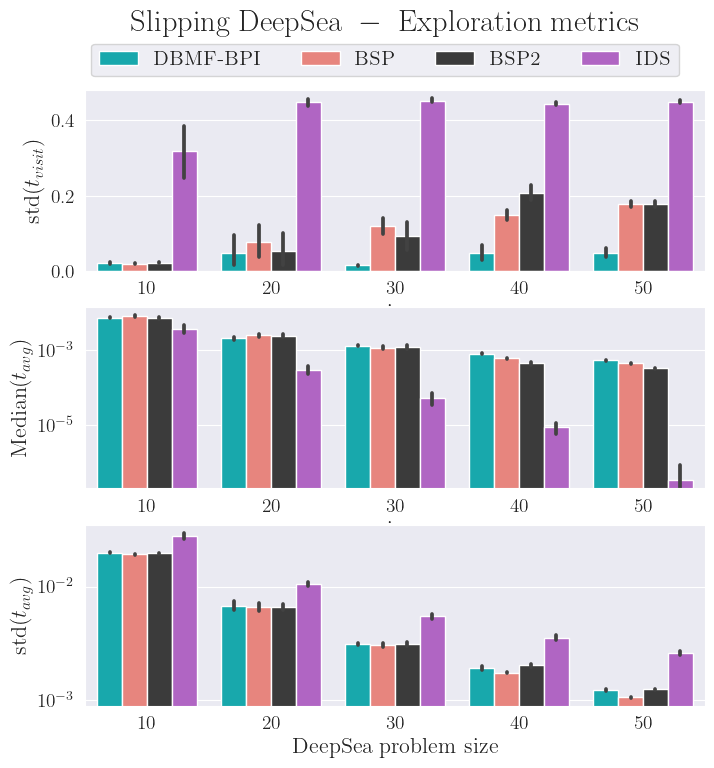

In [67]:
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']

labels_agents = {
    
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative_generative_off_policy': r'\textsc{DBMF-BPI}',
    'boot_dqn_torch': r'\textsc{BSP}',
    'ids': r'\textsc{IDS}',
}
colors = {
    'boot_dqn_torch': '#f8766d',
    'boot_dqn_torch_modified': '#3B3B3B',
    'explorative_generative_off_policy': '#00bfc4',
    'ids': 'mediumorchid',
}
axis_labels = [r'$\mathrm{std}(t_{visit})$', r'$\mathrm{Median}(t_{avg})$', r'$\mathrm{std}(t_{avg})$']

sns.set_style("darkgrid", rc=rc_parameters)
#color_dict = {agent: color for agent, color in zip(AGENTS, colors)}
fig, ax = plt.subplots(3,1, figsize=(8,8))
metrics = ['spread', 'median_avg_visit', 'std_avg_visit']
for i in range(3):
    barplot = sns.barplot(x="size", y=metrics[i], hue="method", data=df, palette=colors, ax=ax[i])
    ax[i].get_legend().remove()
    if i > 0:
        ax[i].set_yscale('log')
    ax[i].set_ylabel(axis_labels[i])
handles, labels = barplot.get_legend_handles_labels()
new_labels = [labels_agents[x] for x in labels]

fig.legend(handles, new_labels,loc='upper center', bbox_to_anchor=(0.5, 0.95), frameon=True, ncols=4)
ax[-1].set_xlabel(r'$\mathrm{DeepSea \ problem \ size}$')
plt.suptitle(r'$\mathrm{Slipping \ DeepSea \ - \ Exploration \ metrics}$') 
plt.savefig('figures/deep_sea_exploration_full.pdf', bbox_inches='tight')

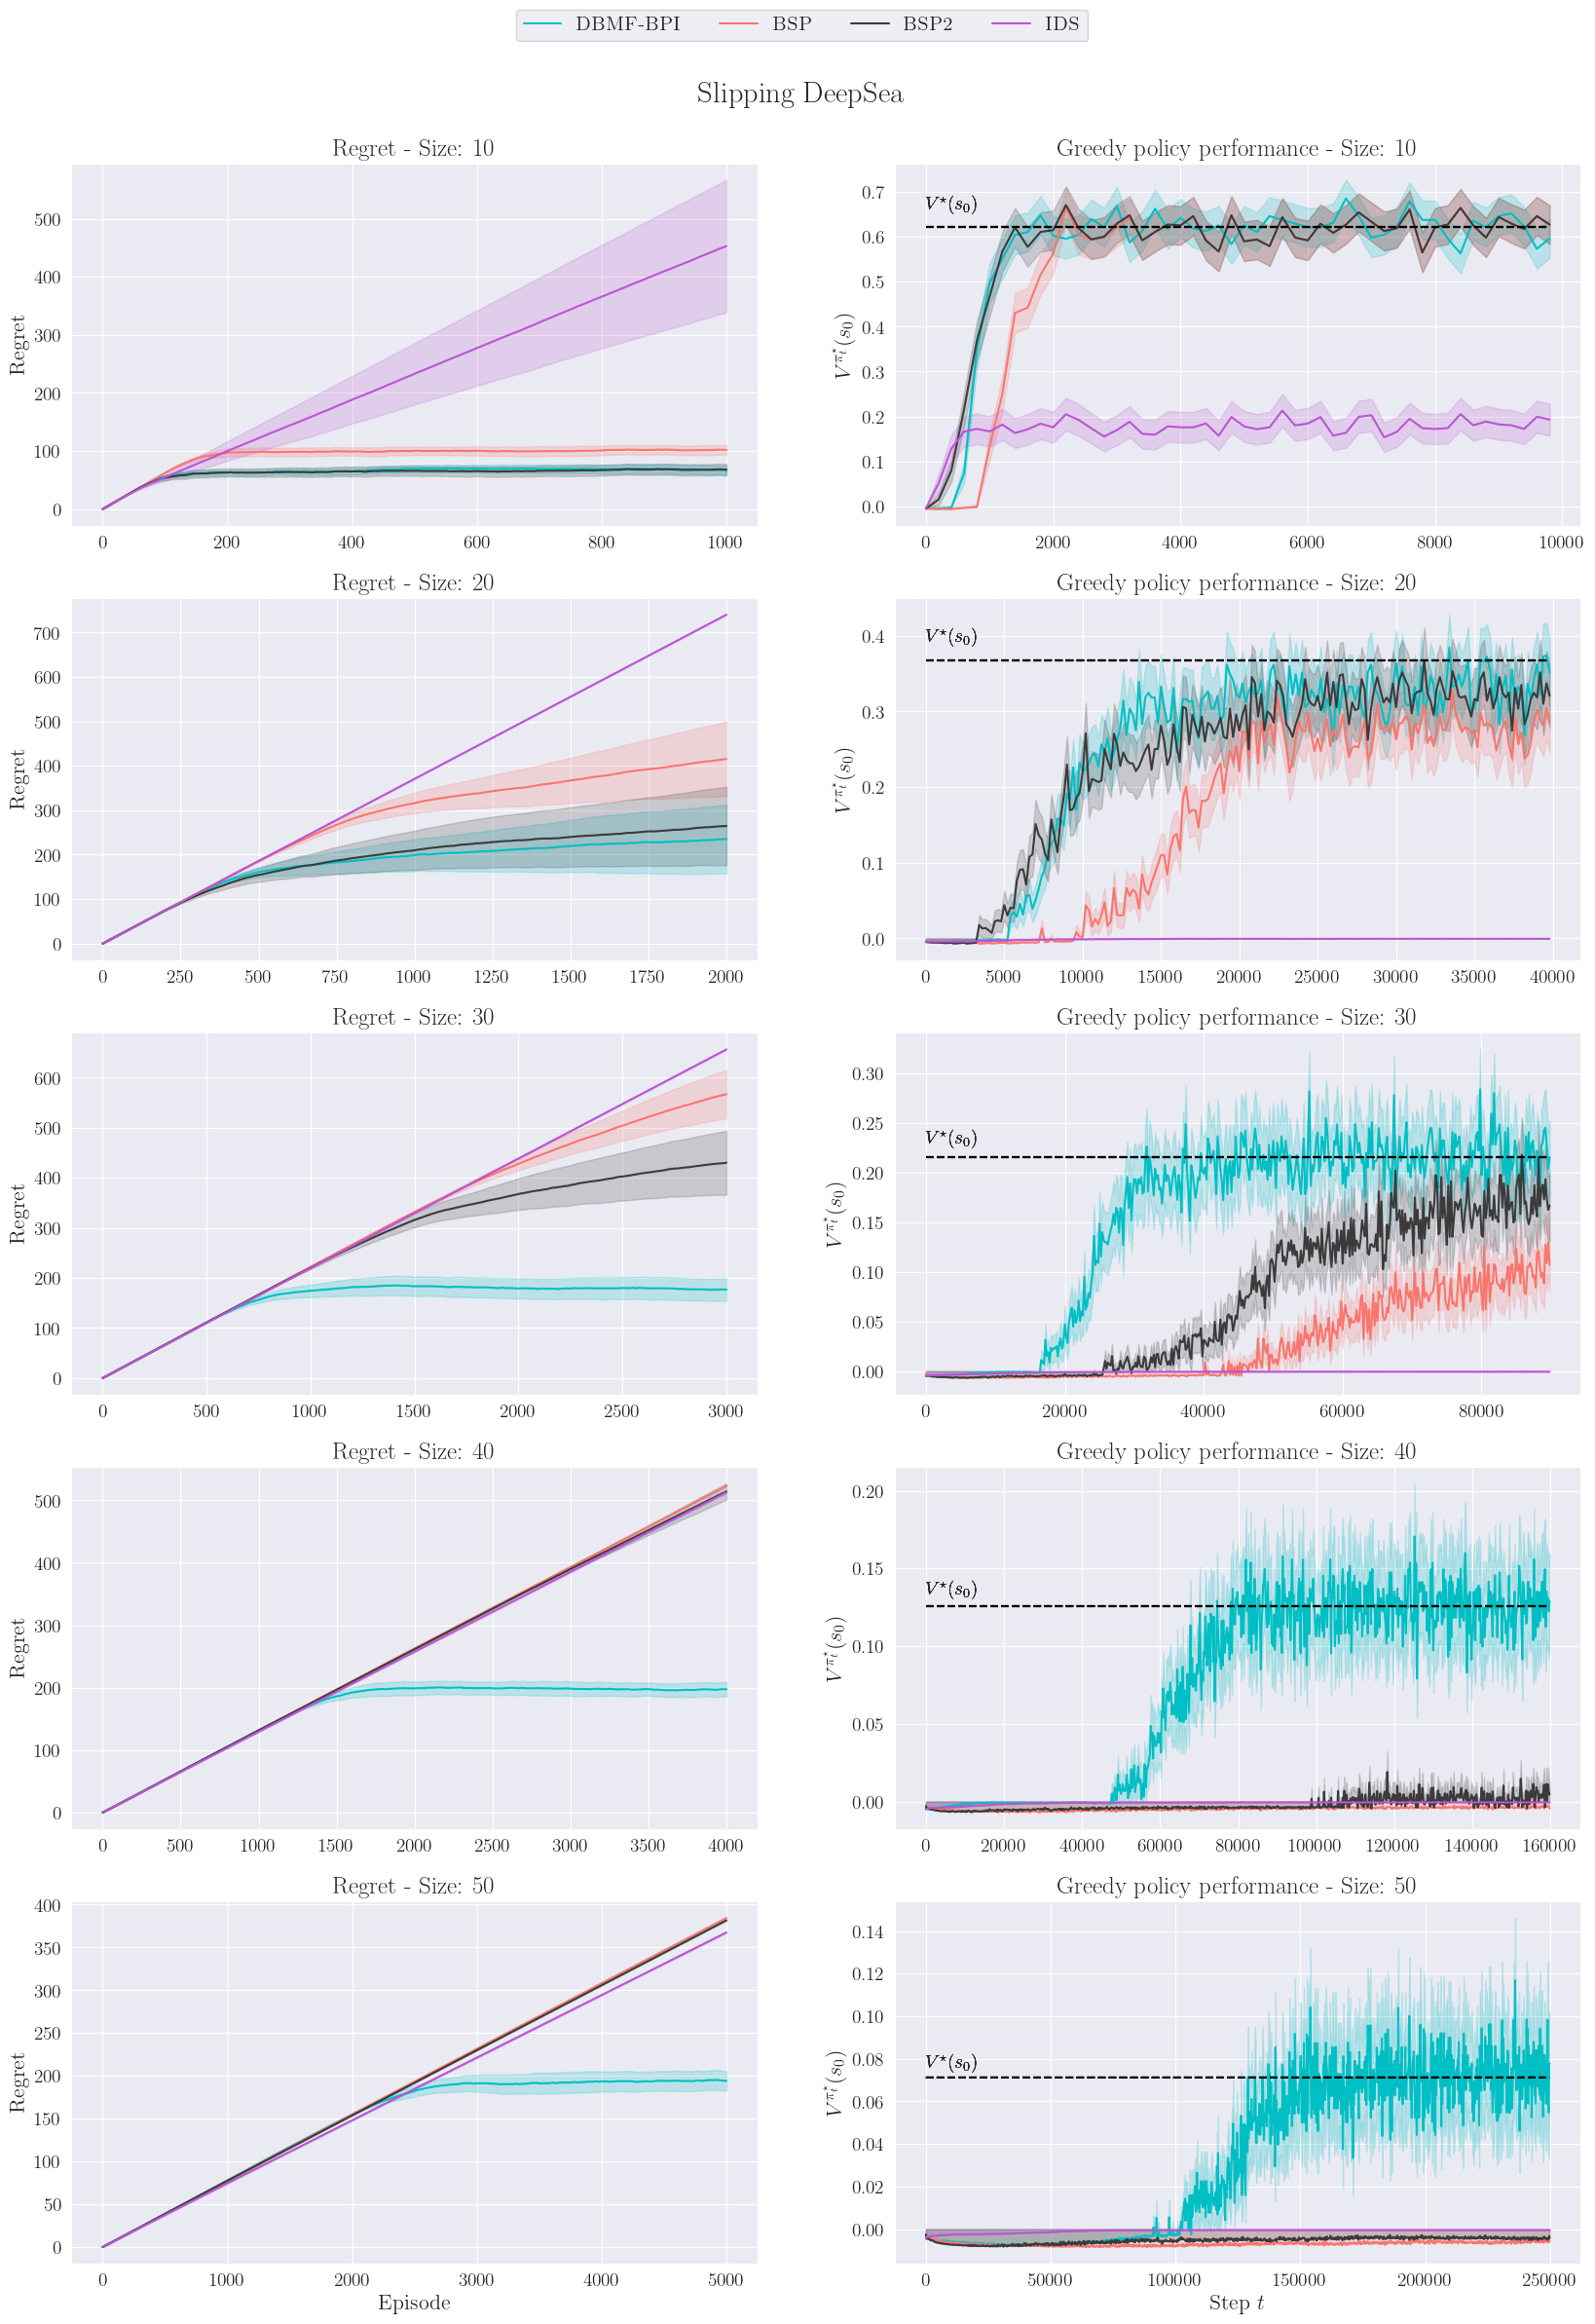

In [70]:
SIZES = [10,20,30,40, 50]
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 5000}
AGENTS = ['explorative_generative_off_policy', 'boot_dqn_torch', 'boot_dqn_torch_modified', 'ids']

colors = {
    'boot_dqn_torch': '#f8766d',
    'boot_dqn_torch_modified': '#3B3B3B',
    'explorative_generative_off_policy': '#00bfc4',
    'ids': 'mediumorchid',
}

labels_agents = {
    
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative_generative_off_policy': r'\textsc{DBMF-BPI}',
    'boot_dqn_torch': r'\textsc{BSP}',
    'ids': r'\textsc{IDS}',
}
sns.set_style("darkgrid", rc=rc_parameters)
fig, ax = plt.subplots(len(SIZES), 2, figsize=(20,28))
raw_data = {}
for axis_id, size in enumerate(SIZES):
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
            raw_data[size] = pickle.load(f)
            mu, ce = CE(np.array(raw_data[size].regret))
            
            t = np.arange(EPISODES[size] + 1)
            ax[axis_id,0].plot(t, mu, color=colors[agent], label=labels_agents[agent])
            ax[axis_id,0].fill_between(t, mu-ce, mu+ce, alpha=0.2, color=colors[agent])
            
            greedy_data = np.array([list(zip(*raw_data[size].greedy_rewards[z]))[1] for z in range(len(raw_data[size].greedy_rewards))])

            mu, ce = CE(greedy_data.swapaxes(1,2).reshape(-1, greedy_data.shape[1]))
            t = np.arange(len(mu)) * 200
            ax[axis_id,1].plot(t, mu, color=colors[agent], label=labels_agents[agent])
            ax[axis_id, 1].fill_between(t, np.clip(mu-ce,0, np.infty), mu+ce, alpha=0.2, color=colors[agent])
            optimal = env.optimal_Q_values[0,0].max()
            ax[axis_id,1].plot(t, np.ones(len(t)) * optimal, 'k--')
            ax[axis_id,0].set_ylabel(r'$\textrm{Regret}$')
            ax[axis_id,1].set_ylabel(r'$V^{\pi_t^\star}(s_0)$')
            ax[axis_id,0].set_title(f'Regret - Size: ${size}$')
            ax[axis_id,1].set_title(f'Greedy policy performance - Size: ${size}$')
            ax[axis_id,1].text(t[0], optimal *1.065, r'$V^\star(s_0)$', fontsize=14)
ax[-1,0].set_xlabel(r'Episode')
ax[-1,1].set_xlabel(r'Step $t$')
                
fig.suptitle('Slipping DeepSea',y=0.91)


handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.94), frameon=True, ncols=len(agents))

plt.savefig('figures/deep_sea_greedy.pdf', bbox_inches='tight')

            

In [42]:
SIZES = [10,20,30,40,50]
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 5000}
AGENTS = ['explorative_generative_off_policy','boot_dqn_torch','boot_dqn_torch_modified',  'ids']


raw_data = {}
data = {size: {agent: None for agent in AGENTS} for size in SIZES}


for size in SIZES:
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        print(f'> Size: {size} - Agent: {agent}')
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
            raw_data[size] = pickle.load(f)
            res = np.array(raw_data[size].training_rewards)
            
            res = res > 0
            res = np.cumsum(res, axis=1)
            data[size][agent] = res

> Size: 10 - Agent: explorative_generative_off_policy
> Size: 10 - Agent: boot_dqn_torch
> Size: 10 - Agent: boot_dqn_torch_modified
> Size: 10 - Agent: ids
> Size: 20 - Agent: explorative_generative_off_policy
> Size: 20 - Agent: boot_dqn_torch
> Size: 20 - Agent: boot_dqn_torch_modified
> Size: 20 - Agent: ids
> Size: 30 - Agent: explorative_generative_off_policy
> Size: 30 - Agent: boot_dqn_torch
> Size: 30 - Agent: boot_dqn_torch_modified
> Size: 30 - Agent: ids
> Size: 40 - Agent: explorative_generative_off_policy
> Size: 40 - Agent: boot_dqn_torch
> Size: 40 - Agent: boot_dqn_torch_modified
> Size: 40 - Agent: ids
> Size: 50 - Agent: explorative_generative_off_policy
> Size: 50 - Agent: boot_dqn_torch
> Size: 50 - Agent: boot_dqn_torch_modified
> Size: 50 - Agent: ids


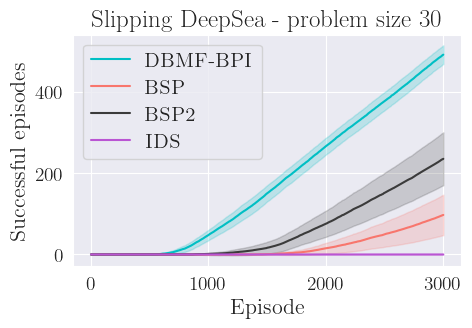

In [44]:
sns.set_style("darkgrid", rc=rc_parameters)
c = 0.95
alpha = c + (1-c)/2

fig, ax = plt.subplots(1,1, figsize=(5,3))
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
labels = {
    'boot_dqn_torch': r'\textsc{BSP}',
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative_generative_off_policy': r'\textsc{DBMF-BPI}',
    'ids': r'\textsc{IDS}',
}
colors = {
    'boot_dqn_torch': '#f8766d',
    'boot_dqn_torch_modified': '#3B3B3B',
    'explorative_generative_off_policy': '#00bfc4',
    'ids': 'mediumorchid',
}


for id_agent, agent in enumerate(AGENTS):
    x = data[30][agent]
    mu = x.mean(0)
    
    N = x.shape[0]
    c = tstudent.ppf(alpha, N-1)

    se = c * x.std(0, ddof=1) / np.sqrt(N)
    plt.plot(range(x.shape[1]), mu, label=labels[agent], color=colors[agent])
    plt.fill_between(range(x.shape[1]), mu-se, mu+se, alpha=0.2, color=colors[agent])

plt.xlabel(r'$\mathrm{Episode}$')
plt.ylabel(r'$\mathrm{Successful \ episodes}$')
# plt.legend()
plt.title(r'$\mathrm{Slipping \ DeepSea}$ - problem size $30$')


# Get the current handles and labels of the plot
handles, labels = plt.gca().get_legend_handles_labels()

# Manually reorder the handles and labels
ordered_handles = handles
ordered_labels = labels

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, ordered_labels)


plt.savefig('figures/deep_sea_successful_episodes_small.pdf', bbox_inches='tight')

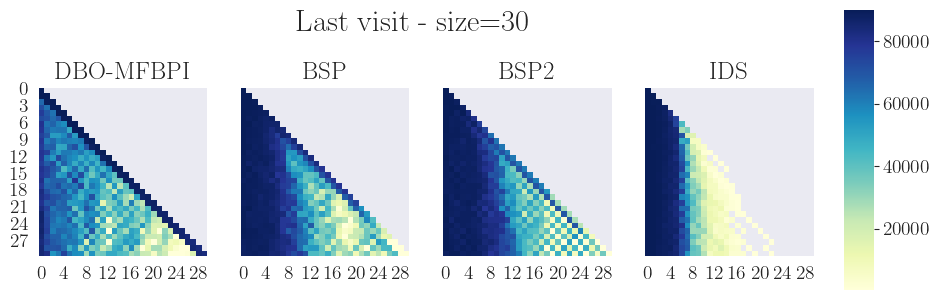

In [64]:
size = 30
sns.set_style("darkgrid", rc=rc_parameters)
fig, ax = plt.subplots(1,4,figsize=(10,4), sharey=True)
cbar_ax = fig.add_axes([.93, .2, .03, .7])
labels = {'explorative_generative_off_policy': 'DBO-MFBPI', 'boot_dqn_torch': 'BSP', 'ids': 'IDS', 'boot_dqn_torch_modified': ' BSP2'}
raw_data = None


AGENTS = ['explorative_generative_off_policy','boot_dqn_torch','boot_dqn_torch_modified',  'ids']


for agent_id, agent in enumerate(AGENTS):
    with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
        raw_data = pickle.load(f)
    last_visit = np.vstack([raw_data.agent_stats[id].last_visit[None,...] for id in range(len(raw_data.agent_stats))])
    last_visit = last_visit.mean(0)


    mask = np.zeros_like(last_visit, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center="light", as_cmap=True)
    last_visit[np.isclose(0, last_visit)] = np.nan
    with sns.axes_style("white"):
        sns.heatmap(last_visit, square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
    ax[agent_id].set_title(labels[agent])

fig.suptitle(f'Last visit - size=${size}$',y=0.9)
plt.savefig(f'figures/last_visit_{size}.pdf', bbox_inches='tight')
plt.show()

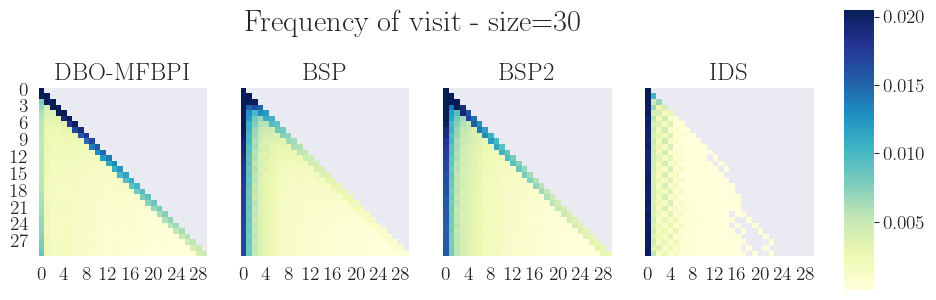

In [63]:
size = 30
sns.set_style("darkgrid", rc=rc_parameters)
fig, ax = plt.subplots(1,4,figsize=(10,4), sharey=True)
cbar_ax = fig.add_axes([.93, .2, .03, .7])
labels = {'explorative_generative_off_policy': 'DBO-MFBPI', 'boot_dqn_torch': 'BSP', 'ids': 'IDS', 'boot_dqn_torch_modified': ' BSP2'}
raw_data = None


AGENTS = ['explorative_generative_off_policy','boot_dqn_torch','boot_dqn_torch_modified',  'ids']


for agent_id, agent in enumerate(AGENTS):
    with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
        raw_data = pickle.load(f)
    last_visit = np.vstack([raw_data.agent_stats[id].frequency_visits[None,...] for id in range(len(raw_data.agent_stats))])
    last_visit = last_visit.mean(0)


    mask = np.zeros_like(last_visit, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center="light", as_cmap=True)
    last_visit[np.isclose(0, last_visit)] = np.nan
    with sns.axes_style("white"):
        sns.heatmap(last_visit, square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
    ax[agent_id].set_title(labels[agent])

plt.suptitle(f'Frequency of visit - size=${size}$', y=0.9)
plt.savefig(f'figures/frequency_visit_{size}.pdf', bbox_inches='tight')
plt.show()